In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot

In [ ]:
df = pd.read_csv('transformer_data.csv')
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    168 non-null    int64  
 1   Y       168 non-null    float64
 2   Ta      168 non-null    float64
 3   S       168 non-null    float64
 4   I       168 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 6.7 KB


(None,
    time          Y        Ta    S          I
 0     1  23.496733  7.083333  0.0  15.899541
 1     2  22.720333  7.116667  0.0  15.861768
 2     3  22.052700  7.216667  0.0  16.121469
 3     4  21.538050  7.250000  0.0  15.447628
 4     5  20.995033  7.316667  0.0  16.258319)

### Task 2.1

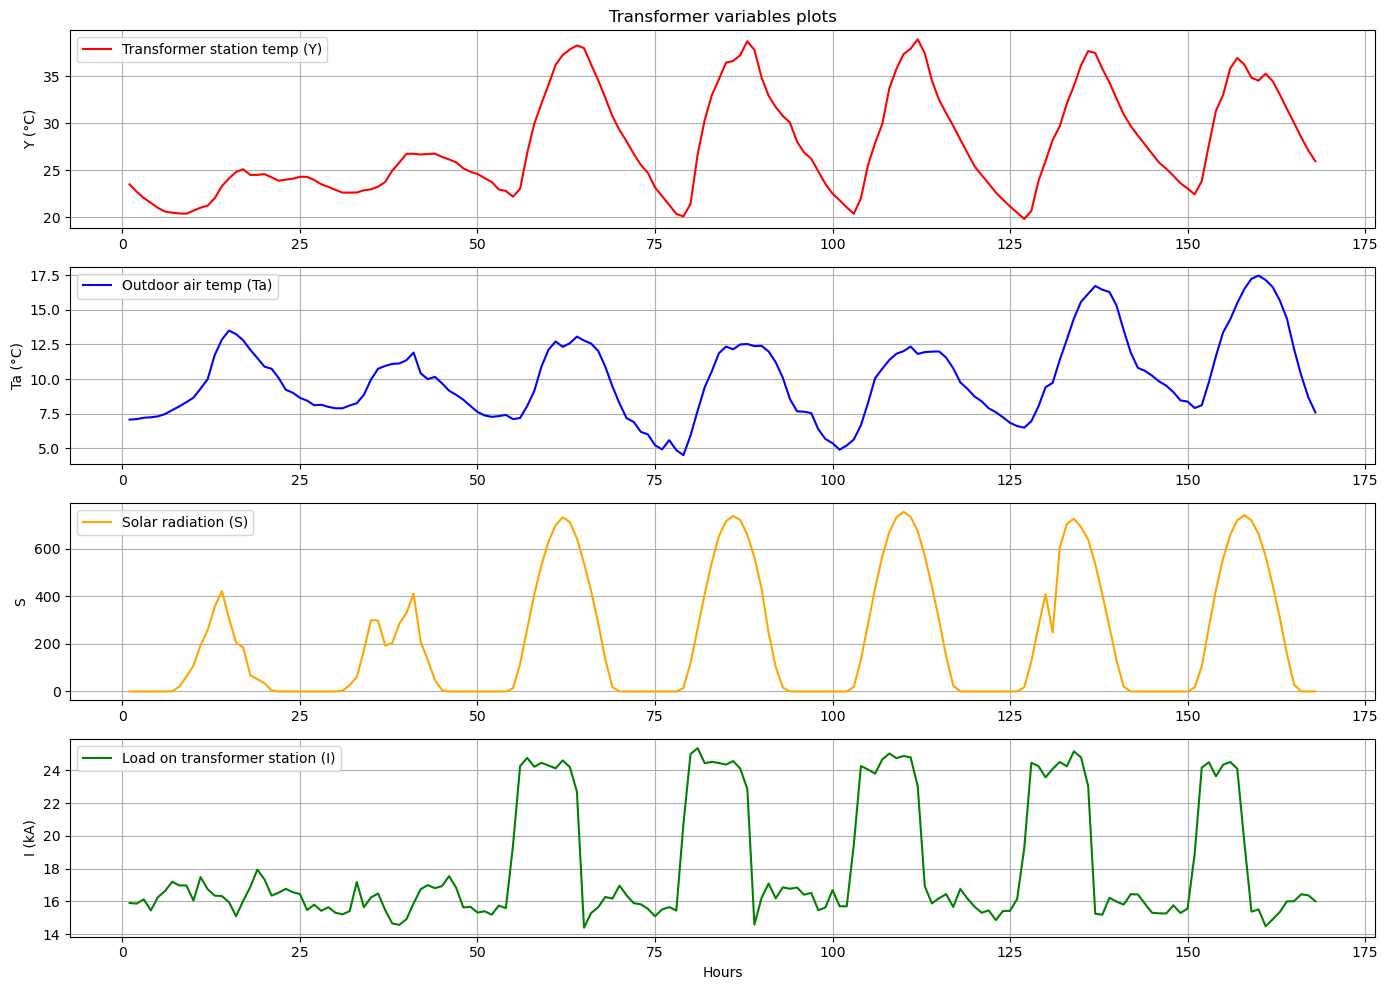

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(df['time'], df['Y'], label='Transformer station temp (Y)', color='red')
plt.ylabel('Y (°C)')
plt.title('Transformer variables plots')
plt.grid()
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df['time'], df['Ta'], label='Outdoor air temp (Ta)', color='blue')
plt.ylabel('Ta (°C)')
plt.grid()
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df['time'], df['S'], label='Solar radiation (S)', color='orange')
plt.ylabel('S')
plt.grid()
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df['time'], df['I'], label='Load on transformer station (I)', color='green')
plt.ylabel('I (kA)')
plt.xlabel('Hours')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


### Task 2.2

In [ ]:
# Kalman filter log-likelihood function
def kf_logLik_dt(par, Y, U):
    A = np.array([[par[0], par[1]], [par[2], par[3]]])
    B = np.array([[par[4], par[5], par[6]], [par[7], par[8], par[9]]])
    Q_lt = np.array([[par[10], 0], [par[11], par[12]]])
    Q = Q_lt @ Q_lt.T
    C = np.array([[1, 0]])
    R = np.array([[par[13] ** 2]])
    X0 = np.zeros((2, 1))
    P0 = np.eye(2) * 20  # initial state value around 20

    Tn = Y.shape[0]
    logLik = 0.0
    x_est = X0
    P_est = P0

    for t in range(Tn):
        u_t = U[t].reshape(-1, 1)
        x_pred = A @ x_est + B @ u_t
        P_pred = A @ P_est @ A.T + Q
        y_pred = C @ x_pred
        S_t = C @ P_pred @ C.T + R
        innov = Y[t] - y_pred
        logLik -= 0.5 * (
            np.log(np.linalg.det(S_t)) + innov.T @ np.linalg.inv(S_t) @ innov + np.log(2 * np.pi)
        )
        K_t = P_pred @ C.T @ np.linalg.inv(S_t)
        x_est = x_pred + K_t @ innov
        P_est = (np.eye(2) - K_t @ C) @ P_pred

    return float(logLik)

# Estimate function
def estimate_dt(start_par, Y, U, lower_bounds=None, upper_bounds=None):
    def neg_logLik(par):
        return -kf_logLik_dt(par, Y, U)

    bounds = list(zip(lower_bounds, upper_bounds)) if lower_bounds and upper_bounds else None

    result = minimize(
        fun=neg_logLik,
        x0=start_par,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 1000, 'disp': True}
    )

    return result


In [ ]:
Y = df[['Y']].values
U = df[['Ta', 'S', 'I']].values

# start parameters and bounds
start_par = np.random.uniform(-1, 1, size=14)
start_par[10:] = np.abs(start_par[10:]) * 0.1

lower_bounds = [-1]*10 + [1e-6]*3 + [1e-6]
upper_bounds = [1]*10 + [1]*3 + [1]

# estimate parameters
result = estimate_dt(start_par, Y, U, lower_bounds, upper_bounds)
result.x, result.fun

C:\Users\Zosia\AppData\Local\Temp\ipykernel_23636\3186862335.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)


(array([ 9.84975772e-01,  7.83057890e-01, -3.23984882e-01, -2.47989441e-01,
        -1.03935666e-01,  1.87660295e-03,  6.55580301e-02,  3.54801775e-01,
         3.75414319e-04,  2.81870800e-01,  2.48396877e-01,  5.68616897e-01,
         9.63593410e-02,  1.68263733e-06]),
 135.27798983458834)

In [20]:
estimated_params = result.x

In [ ]:
# simulate the model to get residuals
def simulate_kf(par, Y, U):
    A = np.array([[par[0], par[1]], [par[2], par[3]]])
    B = np.array([[par[4], par[5], par[6]], [par[7], par[8], par[9]]])
    Q_lt = np.array([[par[10], 0], [par[11], par[12]]])
    Q = Q_lt @ Q_lt.T
    C = np.array([[1, 0]])
    R = np.array([[par[13] ** 2]])
    X0 = np.zeros((2, 1))
    P0 = np.eye(2) * 20

    Tn = Y.shape[0]
    x_est = X0
    P_est = P0
    residuals = []

    for t in range(Tn):
        u_t = U[t].reshape(-1, 1)
        x_pred = A @ x_est + B @ u_t
        P_pred = A @ P_est @ A.T + Q
        y_pred = C @ x_pred
        innov = Y[t] - y_pred
        residuals.append(float(innov))
        S_t = C @ P_pred @ C.T + R
        K_t = P_pred @ C.T @ np.linalg.inv(S_t)
        x_est = x_pred + K_t @ innov
        P_est = (np.eye(2) - K_t @ C) @ P_pred

    return np.array(residuals)


C:\Users\Zosia\AppData\Local\Temp\ipykernel_23636\3639425767.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuals.append(float(innov))


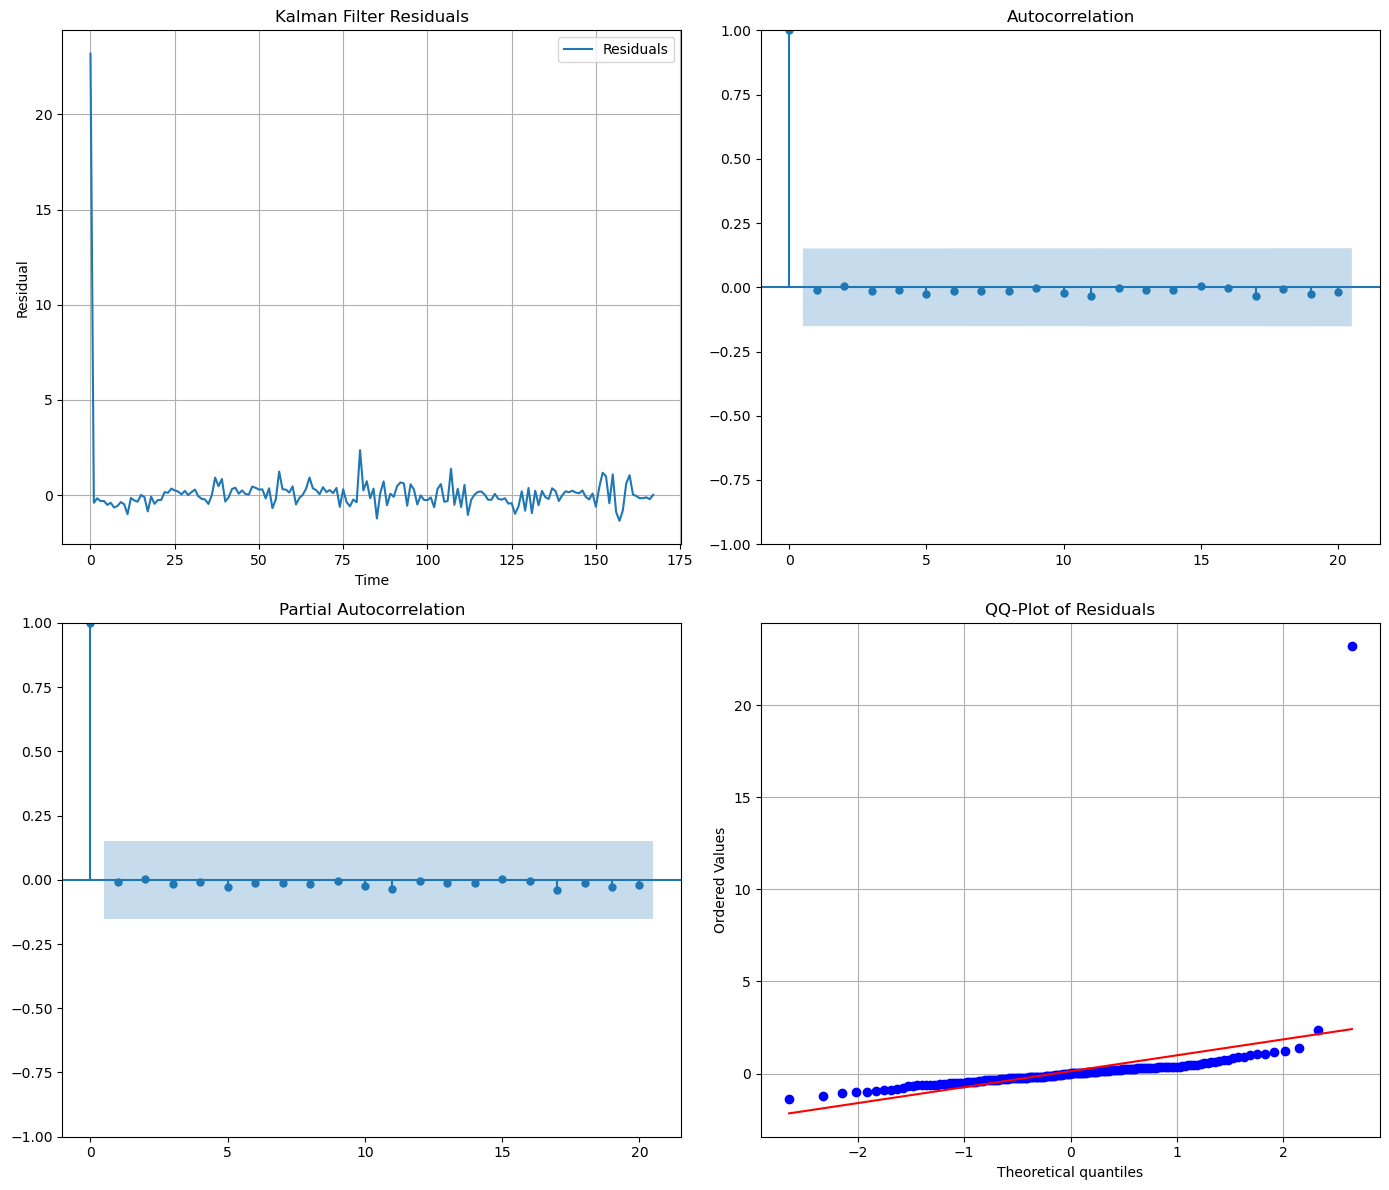

C:\Users\Zosia\AppData\Local\Temp\ipykernel_23636\3186862335.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)


(298.5559796691767, np.float64(342.2914753808223))

In [23]:
residuals = simulate_kf(estimated_params, Y, U)

# Create a single figure with subplots for residuals, ACF, PACF, and QQ plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Residuals plot
axes[0, 0].plot(residuals, label='Residuals')
axes[0, 0].set_title('Kalman Filter Residuals')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid()
axes[0, 0].legend()

# ACF plot
plot_acf(residuals, ax=axes[0, 1], lags=20)
axes[0, 1].set_title('Autocorrelation')

# PACF plot
plot_pacf(residuals, ax=axes[1, 0], lags=20)
axes[1, 0].set_title('Partial Autocorrelation')

# QQ plot
probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('QQ-Plot of Residuals')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

# AIC and BIC 
loglik = kf_logLik_dt(estimated_params, Y, U)
k = len(estimated_params)
n = len(Y)
aic = -2 * loglik + 2 * k
bic = -2 * loglik + k * np.log(n)
aic, bic


### Task 2.3

In [ ]:
# Kalman filter log-likelihood for 2D state-space model
def kf_logLik_2d(par, Y, U):
    A = np.array([[par[0], par[1]], [par[2], par[3]]])
    B = np.array([[par[4], par[5], par[6]], [par[7], par[8], par[9]]])
    Q_lt = np.array([[par[10], 0], [par[11], par[12]]])
    Q = Q_lt @ Q_lt.T
    C = np.array([[1, 0]])  
    R = np.array([[par[13] ** 2]]) 
    X0 = np.zeros((2, 1))
    P0 = np.eye(2) * 20

    Tn = Y.shape[0]
    logLik = 0.0
    x_est = X0
    P_est = P0

    for t in range(Tn):
        u_t = U[t].reshape(-1, 1)
        x_pred = A @ x_est + B @ u_t
        P_pred = A @ P_est @ A.T + Q
        y_pred = C @ x_pred
        S_t = C @ P_pred @ C.T + R
        innov = Y[t] - y_pred
        logLik -= 0.5 * (
            np.log(np.linalg.det(S_t)) +
            innov.T @ np.linalg.inv(S_t) @ innov +
            np.log(2 * np.pi)
        )
        K_t = P_pred @ C.T @ np.linalg.inv(S_t)
        x_est = x_pred + K_t @ innov
        P_est = (np.eye(2) - K_t @ C) @ P_pred

    return float(logLik)

# estimation
def estimate_2d_model(start_par, Y, U, lower_bounds, upper_bounds):
    def neg_logLik(par):
        return -kf_logLik_2d(par, Y, U)

    result = minimize(
        fun=neg_logLik,
        x0=start_par,
        method='L-BFGS-B',
        bounds=list(zip(lower_bounds, upper_bounds)),
        options={'maxiter': 1000, 'disp': True}
    )
    return result


In [25]:
# start parameters and bounds
start_par = np.random.uniform(-1, 1, size=14)
start_par[10:] = np.abs(start_par[10:]) * 0.1
lower_bounds = [-1]*10 + [1e-6]*3 + [1e-6]
upper_bounds = [1]*10 + [1]*3 + [1]

# estimate params
result_2d = estimate_2d_model(start_par, Y, U, lower_bounds, upper_bounds)
result_2d.x, result_2d.fun


C:\Users\Zosia\AppData\Local\Temp\ipykernel_23636\696793185.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)


(array([ 9.99978837e-01,  2.46945313e-01, -1.00000000e+00, -2.43777674e-01,
         2.15293551e-01,  3.76972979e-04,  7.33287653e-02, -5.84856505e-01,
         6.94302314e-03,  7.77295215e-01,  4.57934286e-01,  6.47836340e-01,
         7.85630609e-01,  1.49185073e-06]),
 139.06892545412848)

In [26]:
# We'll use parameters from the earlier 1D estimation as a warm start
smart_start_par = np.array([
    0.985, 0.783, -0.324, -0.248,  # A
    -0.104, 0.00188, 0.0656,        # B row 1
     0.3548, 0.000375, 0.2819,      # B row 2
     0.25, 0.1, 0.1                 # Q_lt lower triangle
])


smart_start_par = np.append(smart_start_par, 1e-3)

lower_bounds = [-1]*10 + [1e-6]*3 + [1e-6]
upper_bounds = [1]*10 + [1]*3 + [1]

# 
result_retry = estimate_2d_model(smart_start_par, Y, U, lower_bounds, upper_bounds)
result_retry.x, result_retry.fun


C:\Users\Zosia\AppData\Local\Temp\ipykernel_23636\696793185.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)


(array([ 1.        ,  1.        , -0.26349759, -0.26747801,  0.02167794,
         0.00116997,  0.07521295,  0.10651092,  0.00104935,  0.20291195,
         0.44199141,  0.17111554,  0.19532882,  0.04179656]),
 132.6167086695473)